# ResNet-50: CIFAR-10 & PyTorch - EXP

In [ ]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER = PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES = 0

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pickle

/home/arjun/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 2
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [5]:
# Specify hyper-parameters
batch_size = 64
num_classes = 10
num_epochs = 85

### CIFAR-10 data pre-processing

In [6]:
# Define transformations for training and test sets-
transform_train = transforms.Compose(
    [
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(
        mean = (0.4914, 0.4822, 0.4465),
        std = (0.0305, 0.0296, 0.0342)),
     ]
)

transform_test = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize(
        mean = (0.4942, 0.4846, 0.4498),
        std = (0.0304, 0.0295, 0.0342)),
     ]
)

In [7]:
train_dataset = torchvision.datasets.CIFAR10(
    root = './data', train = True,
    download = True, transform = transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root = './data', train = False,
    download = True, transform = transform_test
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = batch_size,
    shuffle = True
    )

In [9]:
print(f"len(train_dataset) = {len(train_dataset)} & len(test_dataset) = {len(test_dataset)}")

len(train_dataset) = 50000 & len(test_dataset) = 10000


In [10]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 782 & len(test_loader) = 157


In [11]:
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(781.25, 156.25)

In [ ]:
def calculate_mean_stddev(data_loader):
    '''
    Compute mean and standard-deviation across all channels for the input
    data loader.
    '''
    # VAR(X) = E(X^2) - E(X) ^ 2
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for data, _ in data_loader:
        channels_sum += torch.mean(data, dim = [0, 2, 3])
        # We don't want mean across channels (1st dimension), hence it is ignored.
        
        channels_squared_sum += torch.mean(data ** 2, dim = [0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std_dev = (channels_squared_sum / num_batches - (mean ** 2)) * 0.5
    # You cannot sum the standard deviation as it is not a linear operation.
    
    return mean, std_dev


In [ ]:
# mean_train, std_dev_train = calculate_mean_stddev(data_loader = train_loader)

In [ ]:
# mean_test, std_dev_test = calculate_mean_stddev(data_loader = test_loader)

In [ ]:
# print(f"CIFAR-10 train dataset: mean = {mean_train} & std-dev = {std_dev_train}")
# print(f"CIFAR-10 train dataset: mean = {mean_test} & std-dev = {std_dev_test}")

# Ignore this due to data augmentations which do not reflect the true data statistics!

### Define _ResNet-50_ CNN architecture

In [12]:
class ResNet_Block(nn.Module):
   
    def __init__(
        self, num_inp_channels,
        num_channels, num_bottleneck_channels,
        stride = 1, dropout = 0.2,
        use_1x1_conv = False, first_resblock = False
    ):
        super(ResNet_Block, self).__init__()
        
        self.num_inp_channels = num_inp_channels
        self.num_channels = num_channels
        self.num_bottleneck_channels = num_bottleneck_channels
        self.stride = stride
        self.dropout = dropout
        self.use_1x1_conv = use_1x1_conv
        self.first_resblock = first_resblock
    
        if self.first_resblock:
            self.conv1 = nn.Conv2d(
                in_channels = self.num_inp_channels, out_channels = self.num_bottleneck_channels,
                kernel_size = 1, padding = 0,
                stride = self.stride, bias = False
            )
            self.bn1 = nn.BatchNorm2d(num_features = self.num_bottleneck_channels)
        else:
            self.conv1 = nn.Conv2d(
                in_channels = self.num_inp_channels, out_channels = self.num_bottleneck_channels,
                kernel_size = 1, padding = 0,
                stride = self.stride, bias = False
            )
            self.bn1 = nn.BatchNorm2d(num_features = self.num_bottleneck_channels)
        
        self.conv2 = nn.Conv2d(
            in_channels = self.num_bottleneck_channels, out_channels = self.num_bottleneck_channels,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = self.num_bottleneck_channels)
        self.dropout = nn.Dropout(p = self.dropout)
        
        self.conv3 = nn.Conv2d(
            in_channels = self.num_bottleneck_channels, out_channels = self.num_channels,
            kernel_size = 1, padding = 0,
            stride = 1, bias = False
        )
        self.bn3 = nn.BatchNorm2d(num_features = self.num_channels)
        
        if self.use_1x1_conv:
            self.conv4 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = self.num_channels,
            kernel_size = 1, padding = 0,
            stride = self.stride, bias = False
            )
            self.bn4 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.initialize_weights()

            
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.dropout(F.relu(self.bn2(self.conv2(y))))
        y = self.dropout(F.relu(self.bn3(self.conv3(y))))
        
        if self.use_1x1_conv:
            x = self.bn4(self.conv4(x))
            
        y += x
        # return F.relu(self.dropout(y))
        return F.relu(y)
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        y = F.relu(self.bn1(self.conv1(x)))
        print(f"First conv layer output shape: {y.shape}")
        y = self.bn2(self.conv2(y))
        print(f"Second conv layer output shape: {y.shape}")
        y = self.bn3(self.conv3(y))
        print(f"Third conv layer output shape: {y.shape}")
        
        if self.use_1x1_conv:
            x = self.bn4(self.conv4(x))
            print(f"Downsample with S = 2; identity connection output shape: {x.shape}")
            
        y += x
        print(f"Residual block output shape: {y.shape}")
        return None
    

In [13]:
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 3, out_channels = 64,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = 64)
        
        self.resblock1 = ResNet_Block(
            num_inp_channels = 64, num_channels = 256,
            num_bottleneck_channels = 64, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = True
        )
        
        self.resblock2 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            num_bottleneck_channels = 64, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock3 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            num_bottleneck_channels = 64, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        # Downsample-
        self.resblock4 = ResNet_Block(
            num_inp_channels = 256, num_channels = 512,
            num_bottleneck_channels = 128, stride = 2,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock5 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            num_bottleneck_channels = 128, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock6 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            num_bottleneck_channels = 128, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock7 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            num_bottleneck_channels = 128, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        # Downsample-
        self.resblock8 = ResNet_Block(
            num_inp_channels = 512, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 2,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock9 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock10 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock11 = resblock9 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock12 = resblock9 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock13 = resblock9 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        # Downsample-
        self.resblock14 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 2048,
            num_bottleneck_channels = 512, stride = 2,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock15 = ResNet_Block(
            num_inp_channels = 2048, num_channels = 2048,
            num_bottleneck_channels = 512, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock16 = ResNet_Block(
            num_inp_channels = 2048, num_channels = 2048,
            num_bottleneck_channels = 512, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        # self.avg_pool = nn.AvgPool2d(kernel_size = 3, stride = 2)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1))
        self.output_layer = nn.Linear(in_features = 2048, out_features = 10)
        
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.resblock9(x)
        x = self.resblock10(x)
        x = self.resblock11(x)
        x = self.resblock12(x)
        x = self.resblock13(x)
        x = self.resblock14(x)
        x = self.resblock15(x)
        x = self.resblock16(x)
        x = self.avg_pool(x).squeeze()
        x = self.output_layer(x)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = F.relu(self.bn1(self.conv1(x)))
        print(f"First conv layer output shape: {x.shape}")
        x = self.resblock1(x)
        print(f"ResBlock 1 output shape: {x.shape}")
        x = self.resblock2(x)
        print(f"ResBlock 2 output shape: {x.shape}")
        x = self.resblock3(x)
        print(f"ResBlock 3 output shape: {x.shape}")
        x = self.resblock4(x)
        print(f"ResBlock 4 output shape: {x.shape}")
        x = self.resblock5(x)
        print(f"ResBlock 5 output shape: {x.shape}")
        x = self.resblock6(x)
        print(f"ResBlock 6 output shape: {x.shape}")
        x = self.resblock7(x)
        print(f"ResBlock 7 output shape: {x.shape}")
        x = self.resblock8(x)
        print(f"ResBlock 8 output shape: {x.shape}")
        x = self.resblock9(x)
        print(f"ResBlock 9 output shape: {x.shape}")
        x = self.resblock10(x)
        print(f"ResBlock 10 output shape: {x.shape}")
        x = self.resblock11(x)
        print(f"ResBlock 11 output shape: {x.shape}")
        x = self.resblock12(x)
        print(f"ResBlock 12 output shape: {x.shape}")
        x = self.resblock13(x)
        print(f"ResBlock 13 output shape: {x.shape}")
        x = self.resblock14(x)
        print(f"ResBlock 14 output shape: {x.shape}")
        x = self.resblock15(x)
        print(f"ResBlock 15 output shape: {x.shape}")
        x = self.resblock16(x)
        print(f"ResBlock 16 output shape: {x.shape}")
        x = self.avg_pool(x).squeeze()
        print(f"Average pool output shape: {x.shape}")
        x = self.output_layer(x)
        print(f"Output layer shape: {x.shape}")
        del x
        return None
        
    

### Multi-GPU Training in PyTorch

- [Multi-GPU Examples](https://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html)

- [Data Parallelism](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html)

In [14]:
# Initialize ResNet-50 architecture-
model = ResNet50()

In [ ]:
# Use all available GPUs-
model = nn.DataParallel(model)
model.to(device)

In [16]:
# Sanity check-
x, y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)

In [17]:
x.shape, y.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [18]:
out = model(x)

In [19]:
out.shape

torch.Size([64, 10])

In [20]:
del x, y, out

In [21]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 1, 1]) has 4096 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([256, 64, 1, 1]) has 16384 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([256, 64, 1, 1]) has 16384 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([64, 256, 1, 1]) has 16384 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64

In [22]:
print(f"Total number of parameters in ResNet-50 CNN = {tot_params}")

Total number of parameters in ResNet-50 CNN = 38092362


In [ ]:
'''
# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")
'''

In [ ]:
# Save random initial weights-
# torch.save(model.state_dict(), 'ResNet50_random_weights.pth')

In [ ]:
# Load randomly initialised weights-
'''
test_model = ResNet50()
test_model = nn.DataParallel(test_model)
test_model.to(device)
test_model.load_state_dict(torch.load("ResNet50_random_weights.pth"))
'''

### Train _ResNet-50_ CNN with Learning Rate Scheduler

Training dataset size = 50K, batch-size = 64, number of training steps per epoch = 50K / 64 = 781.25

After an initial LR warmup of 13 epochs or, 10156.25 = 10157 training iterations:

- For the next 32 epochs, or, 25000 steps - until 45rd epoch, use lr = 0.1.

- For the next 25 epochs, or, 19531.25 steps - until 70th epoch, use lr = 0.01.

- For remaining epochs, use lr = 0.001.

In [23]:
boundaries = [35157, 53125]
values = [0.1, 0.01, 0.001]

In [24]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)

In [25]:
# Sanity check-
optimizer.param_groups[0]['lr']

0.0

In [26]:
def decay_function(step, boundaries = [35157, 53125], values = [0.1, 0.01, 0.001]):
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]


In [27]:
class schedule():

    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr
        

In [28]:
# Initial linear LR warmup: 781.25 x 13 = 10156.25 steps in 13 epochs.
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 10157,
    decay_func = decay_function
)

In [29]:
step = 0

In [37]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


In [38]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [39]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

In [40]:
# Initialize parameters saving 'best' models-
best_val_acc = 0
loc_patience = 0

In [41]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(model, train_loader)
    val_loss, val_acc = test_model_progress(model, test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet50_best_model.pth")
        

Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.03batch/s, val_acc=11.7, val_loss=3.12]



epoch: 1 training loss = 2.2741, training accuracy = 15.32%, val_loss = 3.1190, val_accuracy = 11.67% & LR = 0.0077

Saving model with highest val_acc = 11.6700



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.88batch/s, val_acc=31.8, val_loss=1.97]



epoch: 2 training loss = 1.9049, training accuracy = 27.42%, val_loss = 1.9690, val_accuracy = 31.81% & LR = 0.0154

Saving model with highest val_acc = 31.8100



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.80batch/s, val_acc=44.8, val_loss=1.55]



epoch: 3 training loss = 1.6033, training accuracy = 40.19%, val_loss = 1.5520, val_accuracy = 44.79% & LR = 0.0231

Saving model with highest val_acc = 44.7900



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.02batch/s, val_acc=49.6, val_loss=1.48] 



epoch: 4 training loss = 1.3670, training accuracy = 49.83%, val_loss = 1.4799, val_accuracy = 49.63% & LR = 0.0308

Saving model with highest val_acc = 49.6300



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.05batch/s, val_acc=61.9, val_loss=1.11] 



epoch: 5 training loss = 1.1653, training accuracy = 58.09%, val_loss = 1.1146, val_accuracy = 61.88% & LR = 0.0385

Saving model with highest val_acc = 61.8800



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.02batch/s, val_acc=60.2, val_loss=1.17] 



epoch: 6 training loss = 1.0293, training accuracy = 63.79%, val_loss = 1.1697, val_accuracy = 60.23% & LR = 0.0462



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.87batch/s, val_acc=63.6, val_loss=1.04] 



epoch: 7 training loss = 0.9273, training accuracy = 67.60%, val_loss = 1.0392, val_accuracy = 63.65% & LR = 0.0539

Saving model with highest val_acc = 63.6500



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.01batch/s, val_acc=66.6, val_loss=1.02] 



epoch: 8 training loss = 0.8551, training accuracy = 70.49%, val_loss = 1.0242, val_accuracy = 66.57% & LR = 0.0616

Saving model with highest val_acc = 66.5700



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.86batch/s, val_acc=63.1, val_loss=1.14] 



epoch: 9 training loss = 0.8284, training accuracy = 71.59%, val_loss = 1.1353, val_accuracy = 63.13% & LR = 0.0693



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.87batch/s, val_acc=64.1, val_loss=1.12] 



epoch: 10 training loss = 0.8240, training accuracy = 71.65%, val_loss = 1.1164, val_accuracy = 64.12% & LR = 0.0770



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.02batch/s, val_acc=69.9, val_loss=0.879]



epoch: 11 training loss = 0.8396, training accuracy = 71.19%, val_loss = 0.8793, val_accuracy = 69.90% & LR = 0.0847

Saving model with highest val_acc = 69.9000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.87batch/s, val_acc=66.5, val_loss=0.997]



epoch: 12 training loss = 0.8579, training accuracy = 70.56%, val_loss = 0.9968, val_accuracy = 66.53% & LR = 0.0924



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.85batch/s, val_acc=48.2, val_loss=1.89]



epoch: 13 training loss = 0.8761, training accuracy = 69.91%, val_loss = 1.8896, val_accuracy = 48.18% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.86batch/s, val_acc=61.4, val_loss=1.2]  



epoch: 14 training loss = 0.8830, training accuracy = 69.70%, val_loss = 1.2004, val_accuracy = 61.36% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.86batch/s, val_acc=65.5, val_loss=1.07] 



epoch: 15 training loss = 0.8780, training accuracy = 69.93%, val_loss = 1.0685, val_accuracy = 65.46% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.01batch/s, val_acc=60.4, val_loss=1.17] 



epoch: 16 training loss = 0.8729, training accuracy = 70.10%, val_loss = 1.1651, val_accuracy = 60.38% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.91batch/s, val_acc=70.3, val_loss=0.882]



epoch: 17 training loss = 0.8734, training accuracy = 69.97%, val_loss = 0.8819, val_accuracy = 70.31% & LR = 0.1000

Saving model with highest val_acc = 70.3100



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.88batch/s, val_acc=66.1, val_loss=1.05] 



epoch: 18 training loss = 0.8686, training accuracy = 70.27%, val_loss = 1.0511, val_accuracy = 66.13% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.03batch/s, val_acc=62.6, val_loss=1.22] 



epoch: 19 training loss = 0.8646, training accuracy = 70.33%, val_loss = 1.2188, val_accuracy = 62.62% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.86batch/s, val_acc=60.2, val_loss=1.34] 



epoch: 20 training loss = 0.8712, training accuracy = 70.20%, val_loss = 1.3444, val_accuracy = 60.21% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.04batch/s, val_acc=62.6, val_loss=1.14] 



epoch: 21 training loss = 0.8564, training accuracy = 70.64%, val_loss = 1.1353, val_accuracy = 62.62% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.91batch/s, val_acc=63.9, val_loss=1.12] 



epoch: 22 training loss = 0.8524, training accuracy = 70.81%, val_loss = 1.1173, val_accuracy = 63.92% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.86batch/s, val_acc=67.7, val_loss=0.959]



epoch: 23 training loss = 0.8506, training accuracy = 70.80%, val_loss = 0.9592, val_accuracy = 67.70% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.87batch/s, val_acc=69.3, val_loss=0.918]



epoch: 24 training loss = 0.8575, training accuracy = 70.51%, val_loss = 0.9178, val_accuracy = 69.31% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.08batch/s, val_acc=67.5, val_loss=0.986]



epoch: 25 training loss = 0.8527, training accuracy = 70.78%, val_loss = 0.9863, val_accuracy = 67.55% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.05batch/s, val_acc=64.4, val_loss=1.16] 



epoch: 26 training loss = 0.8467, training accuracy = 71.00%, val_loss = 1.1565, val_accuracy = 64.39% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.88batch/s, val_acc=64, val_loss=1.09]   



epoch: 27 training loss = 0.8474, training accuracy = 71.01%, val_loss = 1.0885, val_accuracy = 64.02% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.88batch/s, val_acc=72.1, val_loss=0.82] 



epoch: 28 training loss = 0.8480, training accuracy = 71.06%, val_loss = 0.8200, val_accuracy = 72.13% & LR = 0.1000

Saving model with highest val_acc = 72.1300



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.93batch/s, val_acc=69.6, val_loss=0.923]



epoch: 29 training loss = 0.8458, training accuracy = 71.06%, val_loss = 0.9233, val_accuracy = 69.64% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.89batch/s, val_acc=67.4, val_loss=1.04] 



epoch: 30 training loss = 0.8505, training accuracy = 70.74%, val_loss = 1.0369, val_accuracy = 67.40% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.91batch/s, val_acc=64.5, val_loss=1.08] 



epoch: 31 training loss = 0.8475, training accuracy = 70.89%, val_loss = 1.0789, val_accuracy = 64.50% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.03batch/s, val_acc=64.6, val_loss=1.13] 



epoch: 32 training loss = 0.8383, training accuracy = 71.27%, val_loss = 1.1344, val_accuracy = 64.63% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.03batch/s, val_acc=62.1, val_loss=1.2]  



epoch: 33 training loss = 0.8355, training accuracy = 71.39%, val_loss = 1.2045, val_accuracy = 62.11% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.86batch/s, val_acc=65.9, val_loss=1.11] 



epoch: 34 training loss = 0.8450, training accuracy = 71.19%, val_loss = 1.1149, val_accuracy = 65.88% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.90batch/s, val_acc=63.6, val_loss=1.09] 



epoch: 35 training loss = 0.8462, training accuracy = 71.00%, val_loss = 1.0923, val_accuracy = 63.64% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.92batch/s, val_acc=61, val_loss=1.2]    



epoch: 36 training loss = 0.8534, training accuracy = 70.89%, val_loss = 1.1998, val_accuracy = 61.02% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.90batch/s, val_acc=67.7, val_loss=1]    



epoch: 37 training loss = 0.8442, training accuracy = 71.23%, val_loss = 1.0024, val_accuracy = 67.66% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.04batch/s, val_acc=68.1, val_loss=0.947]



epoch: 38 training loss = 0.8456, training accuracy = 71.24%, val_loss = 0.9473, val_accuracy = 68.10% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.90batch/s, val_acc=57.1, val_loss=1.57]



epoch: 39 training loss = 0.8507, training accuracy = 70.81%, val_loss = 1.5729, val_accuracy = 57.12% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.05batch/s, val_acc=61.5, val_loss=1.33] 



epoch: 40 training loss = 0.8480, training accuracy = 70.82%, val_loss = 1.3338, val_accuracy = 61.54% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.92batch/s, val_acc=58.7, val_loss=1.44] 



epoch: 41 training loss = 0.8435, training accuracy = 71.21%, val_loss = 1.4404, val_accuracy = 58.65% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.95batch/s, val_acc=67.8, val_loss=1.01] 



epoch: 42 training loss = 0.8396, training accuracy = 71.25%, val_loss = 1.0107, val_accuracy = 67.85% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.90batch/s, val_acc=63.5, val_loss=1.17] 



epoch: 43 training loss = 0.8435, training accuracy = 71.18%, val_loss = 1.1691, val_accuracy = 63.48% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.08batch/s, val_acc=66.9, val_loss=0.998]



epoch: 44 training loss = 0.8432, training accuracy = 71.10%, val_loss = 0.9981, val_accuracy = 66.88% & LR = 0.1000



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.08batch/s, val_acc=79.3, val_loss=0.611]



epoch: 45 training loss = 0.8403, training accuracy = 71.17%, val_loss = 0.6112, val_accuracy = 79.28% & LR = 0.0100

Saving model with highest val_acc = 79.2800



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.92batch/s, val_acc=83.7, val_loss=0.471]



epoch: 46 training loss = 0.5683, training accuracy = 80.74%, val_loss = 0.4710, val_accuracy = 83.66% & LR = 0.0100

Saving model with highest val_acc = 83.6600



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.08batch/s, val_acc=85.1, val_loss=0.434]



epoch: 47 training loss = 0.5069, training accuracy = 82.66%, val_loss = 0.4343, val_accuracy = 85.13% & LR = 0.0100

Saving model with highest val_acc = 85.1300



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.89batch/s, val_acc=85.5, val_loss=0.425]



epoch: 48 training loss = 0.4892, training accuracy = 83.24%, val_loss = 0.4255, val_accuracy = 85.55% & LR = 0.0100

Saving model with highest val_acc = 85.5500



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.02batch/s, val_acc=86, val_loss=0.412]  



epoch: 49 training loss = 0.4671, training accuracy = 84.00%, val_loss = 0.4122, val_accuracy = 85.99% & LR = 0.0100

Saving model with highest val_acc = 85.9900



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.87batch/s, val_acc=85.3, val_loss=0.429]



epoch: 50 training loss = 0.4472, training accuracy = 84.74%, val_loss = 0.4291, val_accuracy = 85.30% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.89batch/s, val_acc=86.6, val_loss=0.399]



epoch: 51 training loss = 0.4373, training accuracy = 85.05%, val_loss = 0.3988, val_accuracy = 86.58% & LR = 0.0100

Saving model with highest val_acc = 86.5800



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.90batch/s, val_acc=86.5, val_loss=0.389]



epoch: 52 training loss = 0.4307, training accuracy = 85.21%, val_loss = 0.3887, val_accuracy = 86.49% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.93batch/s, val_acc=86.5, val_loss=0.403]



epoch: 53 training loss = 0.4251, training accuracy = 85.38%, val_loss = 0.4029, val_accuracy = 86.49% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.85batch/s, val_acc=86.6, val_loss=0.391]



epoch: 54 training loss = 0.4155, training accuracy = 85.75%, val_loss = 0.3910, val_accuracy = 86.55% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.03batch/s, val_acc=86.8, val_loss=0.39] 



epoch: 55 training loss = 0.4148, training accuracy = 85.85%, val_loss = 0.3897, val_accuracy = 86.76% & LR = 0.0100

Saving model with highest val_acc = 86.7600



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.86batch/s, val_acc=86.5, val_loss=0.401]



epoch: 56 training loss = 0.4057, training accuracy = 86.17%, val_loss = 0.4012, val_accuracy = 86.53% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.90batch/s, val_acc=86.6, val_loss=0.392]



epoch: 57 training loss = 0.4055, training accuracy = 86.10%, val_loss = 0.3916, val_accuracy = 86.63% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:09<00:00, 17.43batch/s, val_acc=87.1, val_loss=0.377]



epoch: 58 training loss = 0.4035, training accuracy = 86.10%, val_loss = 0.3773, val_accuracy = 87.12% & LR = 0.0100

Saving model with highest val_acc = 87.1200



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.05batch/s, val_acc=86.8, val_loss=0.39] 



epoch: 59 training loss = 0.3970, training accuracy = 86.23%, val_loss = 0.3900, val_accuracy = 86.84% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.90batch/s, val_acc=86, val_loss=0.406]  



epoch: 60 training loss = 0.3968, training accuracy = 86.47%, val_loss = 0.4060, val_accuracy = 86.04% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.91batch/s, val_acc=85.4, val_loss=0.431]



epoch: 61 training loss = 0.3968, training accuracy = 86.23%, val_loss = 0.4308, val_accuracy = 85.42% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.92batch/s, val_acc=86.7, val_loss=0.406]



epoch: 62 training loss = 0.3937, training accuracy = 86.53%, val_loss = 0.4065, val_accuracy = 86.71% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.04batch/s, val_acc=86.5, val_loss=0.403]



epoch: 63 training loss = 0.3876, training accuracy = 86.67%, val_loss = 0.4033, val_accuracy = 86.54% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.94batch/s, val_acc=85.5, val_loss=0.436]



epoch: 64 training loss = 0.3898, training accuracy = 86.78%, val_loss = 0.4355, val_accuracy = 85.50% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.93batch/s, val_acc=85.3, val_loss=0.432]



epoch: 65 training loss = 0.3913, training accuracy = 86.50%, val_loss = 0.4316, val_accuracy = 85.28% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.47batch/s, val_acc=86.4, val_loss=0.423]



epoch: 66 training loss = 0.3837, training accuracy = 86.76%, val_loss = 0.4233, val_accuracy = 86.39% & LR = 0.0100



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.90batch/s, val_acc=87.2, val_loss=0.386]



epoch: 67 training loss = 0.3844, training accuracy = 86.95%, val_loss = 0.3858, val_accuracy = 87.16% & LR = 0.0100

Saving model with highest val_acc = 87.1600



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.92batch/s, val_acc=88.9, val_loss=0.329]



epoch: 68 training loss = 0.3816, training accuracy = 86.99%, val_loss = 0.3294, val_accuracy = 88.88% & LR = 0.0010

Saving model with highest val_acc = 88.8800



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.04batch/s, val_acc=90.4, val_loss=0.284]



epoch: 69 training loss = 0.2800, training accuracy = 90.52%, val_loss = 0.2836, val_accuracy = 90.38% & LR = 0.0010

Saving model with highest val_acc = 90.3800



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.02batch/s, val_acc=90.4, val_loss=0.283]



epoch: 70 training loss = 0.2508, training accuracy = 91.59%, val_loss = 0.2828, val_accuracy = 90.36% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.93batch/s, val_acc=91, val_loss=0.268]  



epoch: 71 training loss = 0.2382, training accuracy = 91.91%, val_loss = 0.2681, val_accuracy = 90.99% & LR = 0.0010

Saving model with highest val_acc = 90.9900



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.10batch/s, val_acc=91.2, val_loss=0.262]



epoch: 72 training loss = 0.2316, training accuracy = 92.13%, val_loss = 0.2625, val_accuracy = 91.22% & LR = 0.0010

Saving model with highest val_acc = 91.2200



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.88batch/s, val_acc=91.1, val_loss=0.261]



epoch: 73 training loss = 0.2238, training accuracy = 92.42%, val_loss = 0.2613, val_accuracy = 91.14% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.05batch/s, val_acc=91.1, val_loss=0.26] 



epoch: 74 training loss = 0.2189, training accuracy = 92.51%, val_loss = 0.2598, val_accuracy = 91.09% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.91batch/s, val_acc=91.1, val_loss=0.263]



epoch: 75 training loss = 0.2113, training accuracy = 92.82%, val_loss = 0.2628, val_accuracy = 91.07% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.88batch/s, val_acc=91.1, val_loss=0.258]



epoch: 76 training loss = 0.2034, training accuracy = 93.10%, val_loss = 0.2579, val_accuracy = 91.13% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.95batch/s, val_acc=91.5, val_loss=0.252]



epoch: 77 training loss = 0.2021, training accuracy = 93.11%, val_loss = 0.2520, val_accuracy = 91.49% & LR = 0.0010

Saving model with highest val_acc = 91.4900



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.99batch/s, val_acc=91.1, val_loss=0.26] 



epoch: 78 training loss = 0.1998, training accuracy = 93.25%, val_loss = 0.2604, val_accuracy = 91.13% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.85batch/s, val_acc=91.3, val_loss=0.254]



epoch: 79 training loss = 0.1953, training accuracy = 93.34%, val_loss = 0.2539, val_accuracy = 91.27% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.91batch/s, val_acc=91.2, val_loss=0.263]



epoch: 80 training loss = 0.1913, training accuracy = 93.36%, val_loss = 0.2629, val_accuracy = 91.25% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.08batch/s, val_acc=91.4, val_loss=0.259]



epoch: 81 training loss = 0.1867, training accuracy = 93.59%, val_loss = 0.2592, val_accuracy = 91.41% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.97batch/s, val_acc=91.8, val_loss=0.253]



epoch: 82 training loss = 0.1857, training accuracy = 93.60%, val_loss = 0.2530, val_accuracy = 91.76% & LR = 0.0010

Saving model with highest val_acc = 91.7600



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.87batch/s, val_acc=91.3, val_loss=0.26] 



epoch: 83 training loss = 0.1811, training accuracy = 93.83%, val_loss = 0.2597, val_accuracy = 91.35% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:08<00:00, 18.04batch/s, val_acc=91.7, val_loss=0.258]



epoch: 84 training loss = 0.1790, training accuracy = 93.97%, val_loss = 0.2583, val_accuracy = 91.68% & LR = 0.0010



Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.97batch/s, val_acc=91.5, val_loss=0.258]


epoch: 85 training loss = 0.1758, training accuracy = 93.90%, val_loss = 0.2582, val_accuracy = 91.50% & LR = 0.0010



In [42]:
print(f"Finished training ResNet-50 CNN on CIFAR-10 dataset")

Finished training ResNet-50 CNN on CIFAR-10 dataset


In [43]:
# Save model from last training epoch-
torch.save(model.state_dict(), "ResNet50_last_epoch_model.pth")

In [44]:
# Save training metrics as Python3 history for later analysis-
with open("ResNet50_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

In [38]:
del model

In [45]:
# Initialize and load 'best' trained parameters from above-
best_model = ResNet50()

# Utilize all available GPUs-
best_model = nn.DataParallel(best_model)
best_model.to(device)
best_model.load_state_dict(torch.load("ResNet50_best_model.pth"))

<All keys matched successfully>

In [46]:
# Get validation loss and accuracy-
val_loss, val_acc = test_model_progress(best_model, test_loader)

Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.95batch/s, val_acc=91.8, val_loss=0.253]


In [47]:
val_loss_last, val_acc_last = test_model_progress(model = model, test_loader = test_loader)

Validation: : 100%|██████████| 157/157 [00:08<00:00, 17.86batch/s, val_acc=91.5, val_loss=0.258]


In [48]:
print(f"ResNet-50 'best' model metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%",
      f"\nlast epoch metrics: val_loss = {val_loss_last:.4f} & val_acc = {val_acc_last:.2f}%"
     )

ResNet-50 'best' model metrics: val_loss = 0.2530 & val_acc = 91.76% 
last epoch metrics: val_loss = 0.2582 & val_acc = 91.50%


In [50]:
del best_model, model

### ResNet-50 training visualizations

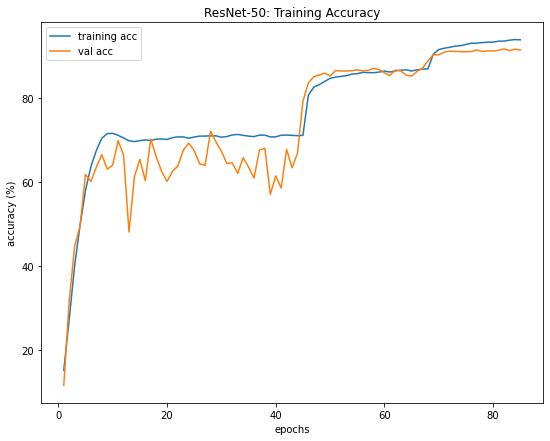

In [51]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("ResNet-50: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

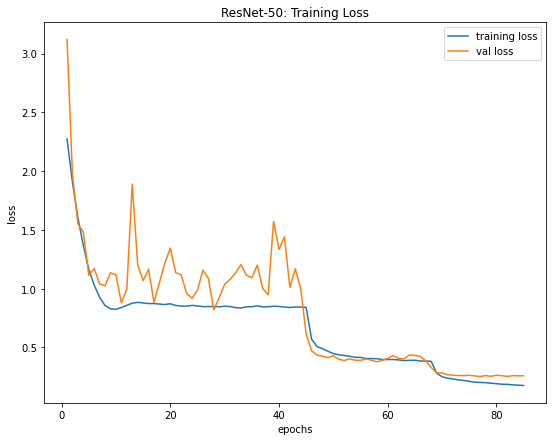

In [52]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("ResNet-50: Training Loss")
plt.show()

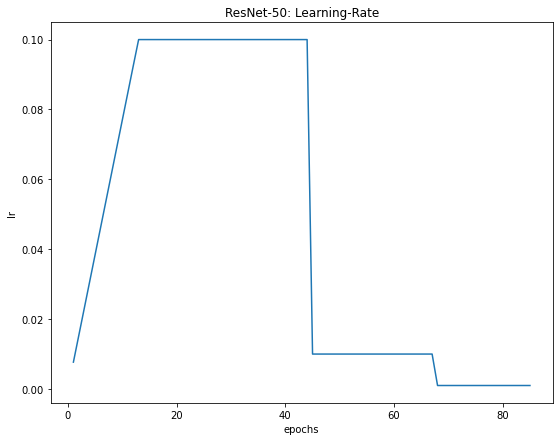

In [53]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-50: Learning-Rate")
plt.show()